In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import rc, rcParams
from scipy import interpolate
import matplotlib.ticker as mticker
import math
import time
import scipy.optimize as optimize
from scipy.integrate import quad

In [2]:
###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 2

In [3]:
#d_cyg_ref = 1.5e+3           # reference distance of the Cygnus-X region, in [pc]
conv_pc_cm = 3.086e+18       # conversion factor from [pc] to [cm]
conv_cm_pc = 3.24e-19        # conversion factor from [cm] to [pc]
conv_s_yr = 3.171e-8         # conversion factor from [sec] to [yr]
conv_yr_sec = 3.154e+7       # conversion factor from [yr] to [sec]
conv_rad_degree = 57.2958    # conversion factor from [rad] to [deg]
c = 2.998e+10                # speed of light, in [cm/s]

### Spatial grid (1D)

In [4]:
L_ref = 40.    # chosen reference length, in [pc]   

N = 40 #100 
Lr = 1
r = np.linspace(start = 0, stop = Lr, num = N+1, endpoint=True)
dr = Lr/N

### Energy grid

In [5]:
Emin = 300.
Emax = 4.e5 
Ekin_fac = 1.1
dimE = int( (np.log(Emax) - np.log(Emin)) / np.log(Ekin_fac)) + 2 # I added another more point to pass E_max!
E = [Emin*(Ekin_fac**i) for i in range(0,dimE)]
E = np.array(E)
dE = (np.append(E[1:], Emin*(Ekin_fac**dimE)) - E)/E

print('Evaluating', dimE, 'Points in energy')
print('Energy grid from', E[0], 'to', E[-1], '-- Energy resolution:', dE[0])
print('')
###############

Evaluating 34 Points in energy
Energy grid from 300.0 to 473316.54313260707 -- Energy resolution: 0.25



### Assign diffusion coefficient

In [6]:
D_ref = 3.8*1.e27 ## this is [cm^2/s]
print(r'Normalization of D, D_0:', D_ref, '\n')
delta = 1./3. 

print(r'Our reference diffusion coefficient (at 1 GeV) is: D_ref =', D_ref, r'cm^2/s =', 
      D_ref*((conv_cm_pc**2)/conv_s_yr), r'$pc^2/yr$')
print("")
D = (D_ref*(E**delta)/(L_ref*c*conv_pc_cm))

Normalization of D, D_0: 1.9e+28 

Our reference diffusion coefficient (at 1 GeV) is: D_ref = 1.9e+28 cm^2/s = 0.06289952696310314 $pc^2/yr$



### Time grid

In [7]:
Nt = int(1.e7)
F = 1./2.      # according to the stability condition
dt = F / ( np.max(D)/dr**2)

t = np.arange(start = 0., stop = Nt*dt, step = dt)

### Summary

In [8]:
print("N = ", N)
print("Nt = ", Nt)
print("")

print("r array: from", np.min(r)*L_ref, 'to', np.max(r)*L_ref, 'pc')
print("t array: from", np.min(t)*L_ref/(c*conv_cm_pc/conv_s_yr)*1e-3, 'to', np.max(t)*L_ref/(c*conv_cm_pc/conv_s_yr)*1e-3, 'kyr')
print("")

print("Space step dr =", dr*L_ref, 'pc')
print("Time step dt =", dt*L_ref/(c*conv_cm_pc/conv_s_yr), 'yr')
print("")

N =  30
Nt =  10000000

r array: from 0.0 to 40.0 pc
t array: from 0.0 to 1813.1083530813885 kyr

Space step dr = 1.3333333333333333 pc
Time step dt = 0.18131085343922418 yr



### Source term

In [9]:
## Source term
alpha = -1.6 ##2.2
Ec = 2.e5 #1e6 # GeV 
Brakn = 3
tau_0 = 1.2e4*conv_yr_sec # 12 kyr -> seconds  #1.2e6*3.1e10 # 1.20 Myr -> seconds    #1.2e4*3.1e10 # 12 kyr -> seconds
Edot = 3.2e34 # erg/s  # Geminga-like. Taken from various references, among them arXiv:2107.07395v1 
L_0 = Edot * 624.151# L/eta at t = 0 -- erg/s -> GeV/s
Q_0 = 3.2 # d^{2}N/dE^{2} -- particles/GeV^2

In [10]:
############# Definition of the density grid ############
U_matrix = np.zeros((len(r), dimE+2), dtype=float)
# density is going to be computed in a square from the 2nd bin to the max-1 bin (from i=1 to i=-2=dimE)

r_cent = np.where(r==0)[0][0]
def Source(tt):    #dN/dtdE from L(dE/dt)*Q_0(dN/dE^2)
    Source_map = np.zeros(U_matrix.shape) 
    Source_map[r_cent, 1:dimE+1] +=\
    (L_ref*conv_pc_cm/c)*L_0*(1+(tt*L_ref*conv_pc_cm/c/tau_0))**(-(Brakn+1)/(Brakn-1)) * Q_0*((E)**(alpha))*np.exp(-E/Ec)  
    #(i.e. a row in the density matrix will consist of 0,vec(x),0, this is why it has len of Nx+2)
    #(L_ref/(c*conv_cm_pc)) is the adimensionalization factor
    return Source_map

The general equation for this system is:
\begin{equation}
\frac{\partial u}{\partial t} (r, t, E_e) = \frac{\partial}{\partial r}\left( D \frac{\partial u}{\partial r} (r, t, E_e) \right) + \mathcal{S}(r, t, E_e) - \frac{\partial }{\partial E_e} \left( \frac{\partial E_e}{\partial t} u (r, t, E_e) \right) 
\end{equation}

### Definitions and energy losses

In [11]:
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

B_field = 3. # microGauss
k_B = 8.62e-5 # eV/K
sigmaT = 6.652e-25 # cm^2
m_ec2 = 0.511*1e6 #eV/c^2 
U_B = 0.224*((B_field/3)**2) *1e-9 # eV/cm^3 --> GeV/cm^3 and B_field in microGauss
U_CMB = 0.26 *1e-9  # eV/cm^3 --> GeV/cm^3 
U_IR = 0.25 *1e-9   # eV/cm^3 --> GeV/cm^3 
U_Opt = 0.055 *1e-9 # eV/cm^3 --> GeV/cm^3 
U_UV1 = 0.37 *1e-9  # eV/cm^3 --> GeV/cm^3 
U_UV2 = 0.23 *1e-9  # eV/cm^3 --> GeV/cm^3 
U_UV3 = 0.12 *1e-9  # eV/cm^3 --> GeV/cm^3 


def f_KN(En, RF="CMB"):
    En = En*1e6 # From GeV to eV!
    if RF == "IR":
        T = 33.07 # K
    elif RF == "Opt":
        T = 313.32 # K
    elif RF == "UV1":
        T = 3249.3 # K
    elif RF == "UV2":
        T = 6150.4 # K
    elif RF == "UV3":
        T = 23209.0 # K
    else:
        T = 2.7 # K
    return ((45/64)*(np.pi**2)*((m_ec2)/k_B*T)**2)/ ((45/64)*(np.pi**2)*((m_ec2)/k_B*T)**2 + ((En/(m_ec2*1e-9))**2))

def df_KN(En, RF="CMB"):
    En = En*1e6 # From GeV to eV!
    if RF == "IR":
        T = 33.07 # K
    elif RF == "Opt":
        T = 313.32 # K
    elif RF == "UV1":
        T = 3249.3 # K
    elif RF == "UV2":
        T = 6150.4 # K
    elif RF == "UV3":
        T = 23209.0 # K
    else:
        T = 2.7 # K
    return -2*En*((45/64)*(np.pi**2)*((m_ec2)/k_B*T)**2)/ ( (m_ec2*1e-9)**2 *((45/64)*(np.pi**2)*((m_ec2)/k_B*T)**2 +\
                                                                           ((En/(m_ec2*1e-9))**2))**2 )

#U_ph = U_CMB + U_Opt + U_IR + U_UV1 + U_UV2 + U_UV3 
C_loss = -(4/3)*c*sigmaT/((m_ec2)**2) * (L_ref*conv_pc_cm)/c    # (L_ref/(c*conv_cm_pc/conv_s_yr))         
C_lossGeV = -(4/3)*c*sigmaT/((m_ec2*1e-9)**2) * (L_ref*conv_pc_cm)/c  
## Units of cm^3/(s GeV^2) * s (to adimensionalize time)

def b_loss(En):
    return C_lossGeV*(U_B + U_CMB*f_KN(En, "CMB") + U_Opt*f_KN(En, "Opt") +\
                + U_IR*f_KN(En, "IR") + U_UV1*f_KN(En, "UV1") + U_UV2*f_KN(En, "UV2") + U_UV3*f_KN(En, "UV3"))*(En**2)
## Unit of GeV, since C_lossGeV is multiplied by E^2 * GeV/cm^3

### db/dE = dbdE_1 + dbdE_2
dbdE_1 = C_lossGeV*(U_B + U_CMB*f_KN(E, "CMB") + U_Opt*f_KN(E, "Opt") +\
                + U_IR*f_KN(E, "IR") + U_UV1*f_KN(E, "UV1") + U_UV2*f_KN(E, "UV2") + U_UV3*f_KN(E, "UV3"))*2*E

dbdE_2 = C_lossGeV*(E**2) *(U_CMB*df_KN(E, "CMB") + U_IR * df_KN(E, "IR") + U_Opt*df_KN(E, "Opt") +\
                            U_UV1*df_KN(E, "UV1") + U_UV2*df_KN(E, "UV2") + U_UV3*df_KN(E, "UV3") )

dbdE = dbdE_1 + dbdE_2
deltaE = 1/2*( np.append(E[1:], Emin*(Ekin_fac**dimE)) -  np.append(Emin/Ekin_fac, E[:-1]) )
# 1/2*( (E_ep+1 - E) + (E - E_ep-1) ) 
deltaE_up = (np.append(E[1:], Emin*(Ekin_fac**dimE)) - E)*dE  # upgoing derivative!!

#U_ph_DE = (U_CMB*(E**2)*(f_KN(np.append(E[1:], Emin*(Ekin_fac**dimE)),"CMB") - f_KN(E,"CMB"))/(2*deltaE)) +\
#    +(U_IR* (E**2)*(f_KN(np.append(E[1:], Emin*(Ekin_fac**dimE)),"IR")  -  f_KN(E,"IR"))/(2*deltaE)) +\
#    +(U_Opt*(E**2)*(f_KN(np.append(E[1:], Emin*(Ekin_fac**dimE)),"Opt") - f_KN(E,"Opt"))/(2*deltaE)) +\
#    +(U_UV1*(E**2)*(f_KN(np.append(E[1:], Emin*(Ekin_fac**dimE)),"UV1") - f_KN(E,"UV1"))/(2*deltaE)) +\
#    +(U_UV2*(E**2)*(f_KN(np.append(E[1:], Emin*(Ekin_fac**dimE)),"UV2") - f_KN(E,"UV2"))/(2*deltaE)) +\
#    +(U_UV3*(E**2)*(f_KN(np.append(E[1:], Emin*(Ekin_fac**dimE)),"UV3") - f_KN(E,"UV3"))/(2*deltaE))
### This is U_ph*E^2 * df_KN/(2*dE)

### Just one loop, energy losses decomposed

The equation that we want to solve has the form (via Crank-Nicholson method): 
    \begin{equation}
    \label{eq:CN1}
    \begin{split}
        \frac{u^{\tau+1}_{i,\epsilon} - u^{\tau}_{i,\epsilon}}{\Delta t} =  \frac{D}{\Delta r^2} \times \frac{1}{2} \left[ (u^{\tau}_{i+1,\epsilon} - 2u^{\tau}_{i,\epsilon} + u^{\tau}_{i-1,\epsilon} )  + (u^{\tau+1}_{i+1,\epsilon} - 2u^{\tau+1}_{i,\epsilon} + u^{\tau+1}_{i-1,\epsilon} ) \right] + \\ - \frac{b(E_{\epsilon})}{2}\times\frac{(u^{\tau}_{i,\epsilon+1} - u^{\tau}_{i,\epsilon-1}) + (u^{\tau+1}_{i,\epsilon+1} - u^{\tau+1}_{i,\epsilon-1})}{2\Delta E} + \frac{1}{2} \left(u^{\tau}_{i,\epsilon} +  u^{\tau+1}_{i,\epsilon}\right) \frac{4}{3}\, \frac{c \, \sigma_{T} \, U_B }{(m_ec^2)^2}   2 E_{\epsilon} + \\ + \frac{1}{2} \left(u^{\tau}_{i,\epsilon} + u^{\tau+1}_{i,\epsilon}\right) \frac{4}{3}\, \frac{c \, \sigma_{T} U_{ph}}{(m_ec^2)^2} \left(2 E_{\epsilon} \mathcal{F}_{KN}(E_{\epsilon}) +  E_{\epsilon}^2 \mathcal{F'}_{KN}(E_{\epsilon}) \right)   + \\ + S(r_i, E_{\epsilon}, t^{\tau+1/2}) \, \, .
        \end{split}
    \end{equation}
    
Instead of taking the derivative in energy as $\frac{u_{i,\epsilon+1} - u_{i,\epsilon-1}}{2\Delta E}$ we take just the up-going derivative $\left( \frac{u_{i,\epsilon+1} - u_{i,\epsilon}}{\Delta E_{up}} \right)$, so that instead of $\Delta E = 1/2 \times (E_{\epsilon+1} - E_{\epsilon-1})$ we use $\Delta E_{up} = E_{\epsilon+1} - E_{\epsilon}$. The $\frac{1}{2}$ term is not necessary either, since it came from the fact that we were taking two energy steps for differentiating the density.

In [12]:
################# Crank-Nicholson coefficients ####################

# terms for first equation (t-> t+Dt/2)
alpha_r = D*dt/(2*dr**2)    # alpha_r
DIAG1_r = 1 + 2*alpha_r     # 1+2*alpha_r        ## Index 1 here means left side of the equation: with the terms of density^(t+1)
L1_r = -alpha_r
U1_r = -alpha_r
DIAG2_r = 1 - 2*alpha_r     # 1-2*alpha_r
L2_r = alpha_r
U2_r = alpha_r

U1_r = np.array(U1_r)
L1_r = np.array(L1_r)
U2_r = np.array(U2_r)
L2_r = np.array(L2_r)

# terms for second equation (t+Dt/2 -> t+Dt)
DIAG1_ep = 1 - (dbdE*dt) - b_loss(E)/(2*deltaE_up) * dt
U1_ep = + b_loss(E)/(2*deltaE_up) * dt
DIAG2_ep = 1 + (dbdE*dt) + b_loss(E)/(2*deltaE_up) * dt
U2_ep = - b_loss(E)/(2*deltaE_up) * dt

In [13]:
#### Running!!! #########
print('Running the solver!\n')

t0 = time.time() 

Totaltime = 70 #100 # kyrs
simsteps = round(Totaltime/(dt *L_ref*conv_pc_cm/c *conv_s_yr/1000)) #int(1e6)
print('Number of iterations:', simsteps)

S_ = []
Inject = []
print('Total simulation time:', np.round(simsteps*dt *L_ref*conv_pc_cm/c *conv_s_yr /1000, 2), 'kyrs')
for it in range(simsteps):         
    U_matrix_t = U_matrix
    for ie in range(dimE-1, -1, -1): 
        
        ##First equation:
        Alpha_CN1 = tridiag(np.ones(N)*L1_r[ie], np.ones(N+1)*DIAG1_r[ie], np.ones(N)*U1_r[ie])
        Beta_CN1 = tridiag(np.ones(N)*L2_r[ie], np.ones(N+1)*DIAG2_r[ie], np.ones(N)*U2_r[ie])
        S_av = dt*(Source(t[it])[:, ie+1] + Source((t[it] + dt))[:, ie+1])/2
        U_matrix[:, ie+1] = np.dot( (np.dot(Beta_CN1, (U_matrix[:, ie+1])) + S_av), np.linalg.inv(Alpha_CN1.T))
                
        ##Second equation:
        #Alpha_CN2 = tridiag(np.ones(dimE-1), DIAG1_ep, U1_ep[:-1]) 
        #Beta_CN2 = tridiag(np.ones(dimE-1), DIAG2_ep, U2_ep[:-1])
        #S_av2 = dt/2*(Source((t[it] + dt))[ir, :] + Source((t[it] + dt/2))[ir, :])/2
        U_matrix[:, ie+1] = (DIAG2_ep[ie]*U_matrix_t[:, ie+1] + U2_ep[ie]*U_matrix_t[:, ie+2] -\
                             U1_ep[ie]*U_matrix[:, ie+2])/DIAG1_ep[ie]
                                                    # + S_av2
            
        
    if (it%1e4==0):
        S_.append(U_matrix.copy())

print((time.time() - t0)/3600, 'h')           

Running the solver!

Number of iterations: 386130
Total simulation time: 70.0 kyrs
1.4153104644351535 h


In [14]:
dV = 1. #(dr*L_ref*conv_pc_cm)**3

### PLOTS!

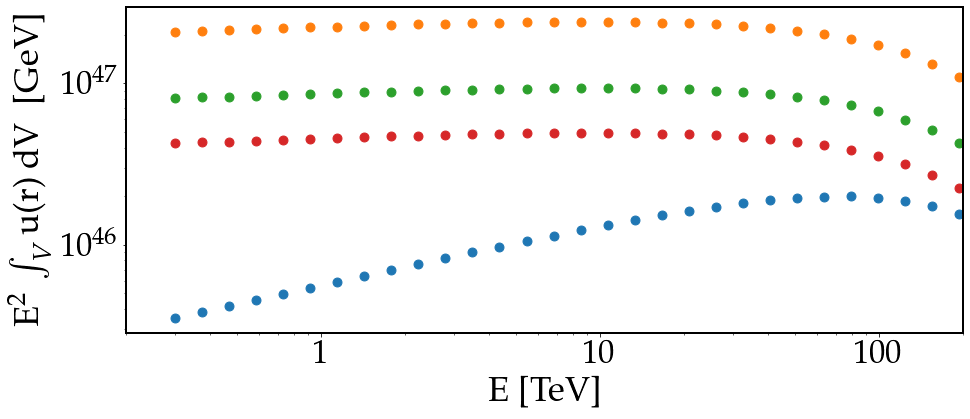

In [15]:
slope = 2
 
fig = plt.figure(figsize=(15,6))
for step_, Su in enumerate(S_):
    if not step_%10==0:
        continue
    sumU_2D = [np.sum(Su[:, iiee])  for iiee in range(1, dimE+1) ]

    plt.scatter(E, sumU_2D*(E**slope), marker='o',  s=80, label='Step:' + str(step_)) 
    
plt.xlabel(' E [$\mathrm{TeV}$]',fontsize=35)
#plt.ylabel('E$^{' + str(slope) + '} \,\sum_{r, z} \,$u(r, z)$\,\,\, [$GeV$^{' + str(round(slope-1,2)) + '}\,$cm$^{-3}]$', labelpad=10, fontsize=28)
if slope == 2:
    plt.ylabel('E$^{' + str(slope) + '} \,\int_{V} \,$u(r) dV$\,\,\, $[GeV]', labelpad=10, fontsize=35)
else:
    plt.ylabel('E$^{' + str(slope) + '} \,\int_{V} \,$u(r) dV$\,\,\, [$GeV$^{' + str(round(slope-1,2)) + '}\,$]', labelpad=10, fontsize=35)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1000, 10000, 100000], ['1', '10', '100'], fontsize=33)
plt.yticks(fontsize=33)
#plt.legend(fontsize = 20., ncol = 4, frameon=True, loc="lower right")
#plt.legend(loc='best', fontsize = 20, ncol = 2, frameon=False)
plt.xlim(left=200, right=2.e5)
#plt.ylim(bottom=4e47)
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/TeV_electons_Spectrum2_B200.png')
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/TeV_electons_Spectrum2_B.pdf')

plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


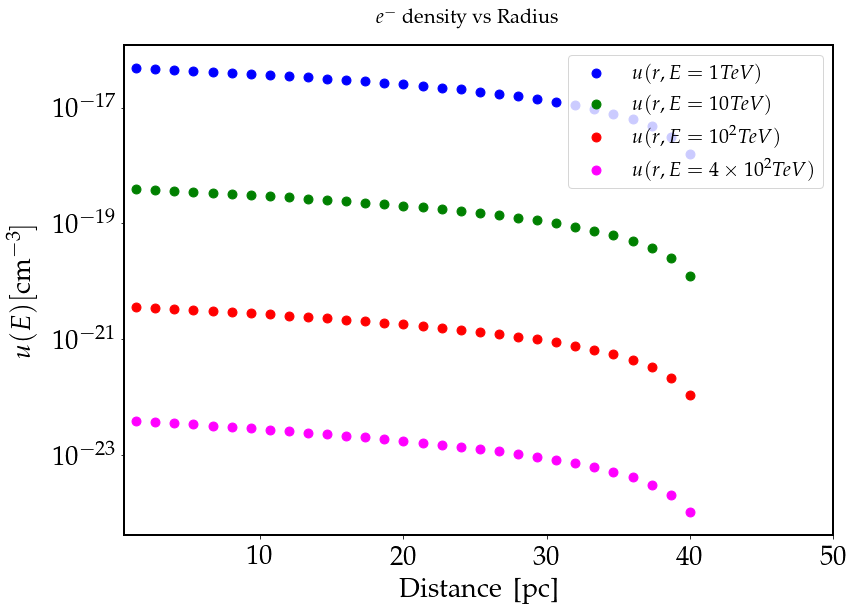

In [16]:
import scipy.optimize as optimize

# Propagated spectrum
plt.figure(figsize=(12.7, 9.))
plt.suptitle('$e^{-}$ density vs Radius', fontsize=20, y = 0.94)

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=27)
ax.tick_params(axis='both', which='minor', labelsize=27)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 7

Ev_En = 1.e3 #1TeV
En_indx = np.argmin(np.abs(E-Ev_En))
plt.scatter(r*L_ref, U_matrix[:, En_indx]/dV, marker='o', color='blue', s=80, label=r'$u(r, E=1 TeV)$')


Ev_En = 1.e4 #10TeV
En_indx = np.argmin(np.abs(E-Ev_En))
plt.scatter(r*L_ref, U_matrix[:, En_indx]/dV, marker='o', color='green', s=80, label=r'$u(r, E=10 TeV)$')

Ev_En = 1.e5 #100TeV
En_indx = np.argmin(np.abs(E-Ev_En))
plt.scatter(r*L_ref, U_matrix[:, En_indx]/dV, marker='o', color='red', s=80, label=r'$u(r, E=10^2 TeV)$')

Ev_En = E[-1] #400TeV
En_indx = np.argmin(np.abs(E-Ev_En))
plt.scatter(r*L_ref, U_matrix[:, En_indx]/dV, marker='o', color='magenta', s=80, label=r'$u(r, E=4\times 10^2 TeV)$')

plt.xlabel('Distance\, [$\mathrm{pc}$]',fontsize=27)
plt.ylabel('$u(E) [\mathrm{cm^{-3}}]$', labelpad=15, fontsize=27)
f = mticker.ScalarFormatter(useMathText=True)
#plt.text(10., 1.e+3, 'Cygnus X', fontsize=23)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best', fontsize = 20)
plt.xlim(left=0.5, right=L_ref+10)
#plt.ylim(bottom=3.e27, top=1.1e28)
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/TeV_electons-SpectrumvsR2_B200.png')
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/TeV_electons-SpectrumvsR2.pdf')
plt.show()

## Gamma-ray production via IC

In [17]:
## ---- Computation of the grey body constants. Each ISRF has a constant

kT = k_B*np.array([2.73, 33.07, 313.32, 3249.3, 6150.4, 23209.0]) #eV
U = np.array([0.26, 0.25, 0.055, 0.37, 0.23, 0.12]) # eV/cm^3
h_reduced = 6.58e-16  # [eV*s]  --> 1.054571817e−34 J⋅s
h = 2.*np.pi*h_reduced # [eV*s]   #h = 6.626e-34 #[J/Hz]

def BB_Density(E_, kT_): # integral of 1/cm^3 with energy
    return ((E_)**3/ ((np.pi**2)*(c*h_reduced)**3) )* (1/(np.exp(E_/kT_)-1) ) 

def BB(E_, kT_): # cm^-3 eV^-1
    return ((E_)**2/ ((np.pi**2)*(c*h_reduced)**3) )* (1/(np.exp(E_/kT_)-1) ) 

RenF = []
for kT_i, U_i in zip(kT, U):
    BB_Edensity = quad(BB_Density, 0, np.inf, args=(kT_i)) 
                                    ## ---- Integral from 0 to inf to compute energy density of the black body
    RenF.append(U_i/BB_Edensity[0]) ## ---- Grey-body constant, just dividing real energy density by BB E density
    print(U_i/BB_Edensity[0])

0.9891400269413738
4.4171103159663925e-05
1.2059942433386732e-09
7.014189559864039e-13
3.396639111963733e-14
8.739579729033134e-17


<ipython-input-17-8745d5bced43>:9: RuntimeWarning: overflow encountered in exp
  return ((E_)**3/ ((np.pi**2)*(c*h_reduced)**3) )* (1/(np.exp(E_/kT_)-1) )


In [18]:
## ---- We have here the computation of IC emission using the grey body spectra of the ISRFs ----

Gamma_e = E/(m_ec2*1e-9)

## ---- Definition of the gamma-ray energy where we are computing the IC flux ----
## ---- I take as range from min energy (where we compute flux of electrons)/10 to max electron energy ----
## ---- Logarithmically spaced energy bins, where the Ekin factor controls the size of the bins: 
## ---- Ekin_fac = 1.05 means that the E_i+1/E_i = 1.05 ----
Ekin_fac = 1.03
dimE_gamma = int( (np.log(Emax) - np.log(Emin/10)) / np.log(Ekin_fac)) + 2 - 1 # I added another more point to pass E_max!
E_gamma = [Emin/10.*(Ekin_fac**i) for i in range(dimE_gamma)]
dE_gamma = (np.append(E_gamma[1:], Emin/10.*(Ekin_fac**dimE_gamma)) - E_gamma)


## ---- Here is where the computations starts ----
t0= time.time()   
epsilon = []
for kT_i, Ren_ in zip(kT[:], RenF[:]):  ## ---- Loop over the ISRFs. There are 6 fields----
                                      ## ---- RenF is the list grey body constants ----
    epsilon_Ph_list = []
    E_ph = np.logspace(start=np.log10(kT_i/10.), stop=np.log10(kT_i*15.), num=20) ## ---- ISRF photon energy ----
    dE_ph = (E_ph[1:] - E_ph[:-1]) # eV
    for Ph_En, dPh_En in zip(E_ph, dE_ph):  ## ---- Loop over ISRF photon energies; To integrate over black body spectrum ----
                        ## ---- E_ph is also used to compute probability of producing IC photons ----
        BB = Ren_*(Ph_En**2/ ((np.pi**2)*(c*h_reduced)**3) )* (1/(np.exp(Ph_En/kT_i)-1) )
                            ## ---- Black-body equation: dn_ph/dE_ph -> 1/(cm^3 E_ph) ----
        Ph_n = BB*dPh_En ## ---- Dn_ph (integrated element) ----
        #print(Ph_n)
        epsil = []
        sigmaIC_Eg = (3/4)*sigmaT*((m_ec2*1e-9)**2)/(Ph_En*1e-9)/(E**2) #/E_g
        for ieg, E_g in enumerate(E_gamma):
            p = 4*Ph_En*1e-9*E[E>=E_g]/((m_ec2*1e-9)**2)
            q = E_g/(4*Ph_En*1e-9*(Gamma_e[E>=E_g]**2) *(1 - E_g/E[E>=E_g]))
            q[q >= 1.] = 1.
            q[q < 1/(4*Gamma_e[E>=E_g]**2)] = 1. 
            
            Totq = 2*q * np.log(q) + (1+2*q)*(1-q) + ((1-q)*(p*q)**2)/(2*(1 + p*q))
            ## ---- Formula 18 of Hermes paper and 3 of our paper ----
            epsi = ( Ph_n * sigmaIC_Eg[E>=E_g]*Totq)*\
                    (c/(4*np.pi)*(U_matrix[:, 1:-1][:, E>=E_g]/dV)*(dE*E)[E>=E_g])  

            epsil.append(np.sum(np.array(epsi), axis = 1).T)   # Integrate over electron energy      
        epsilon.append(np.array(epsil)*4.*np.pi)
        
    epsilon_Ph_list.append(np.sum(np.array(epsilon), 0))  #Integrate over background photon Energy (E_ph)
                                                              ## Integrating BB spectrum
    
epsilon = np.sum(np.array(epsilon_Ph_list), 0) # Integrate over all background fields (T_i)
                                                   
## Units is density/(s GeV)
print(np.array(epsilon).shape) ## shape is (Number of gamma-ray maps (M_A values), Ebins, zbins, rbins)
print((time.time() - t0)/3600, 'h')

(322, 31)
0.0004044321510526869 h


### Gamma-ray spectrum

In [19]:
## ---- HAWC flux band ----

HAWK_band_sup = [8.84e-9, 6.34e-9, 6.31e-9]  # Units of GeV/(cm^2 s)
HAWK_band_low = [5.68e-9, 4.59e-9, 3.396e-9]
HAWK_band_En = [8000., 20000., 40000.]

<ipython-input-20-d1171129ca91>:13: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [8000.0 20000.0 40000.0] in fill_betweenx(). This will become an error two minor releases later.
  plt.fill_between(HAWK_band_En, HAWK_band_sup, HAWK_band_low, 'r', alpha=0.8, label='HAWC') ##Be careful, this is E^2*flux
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


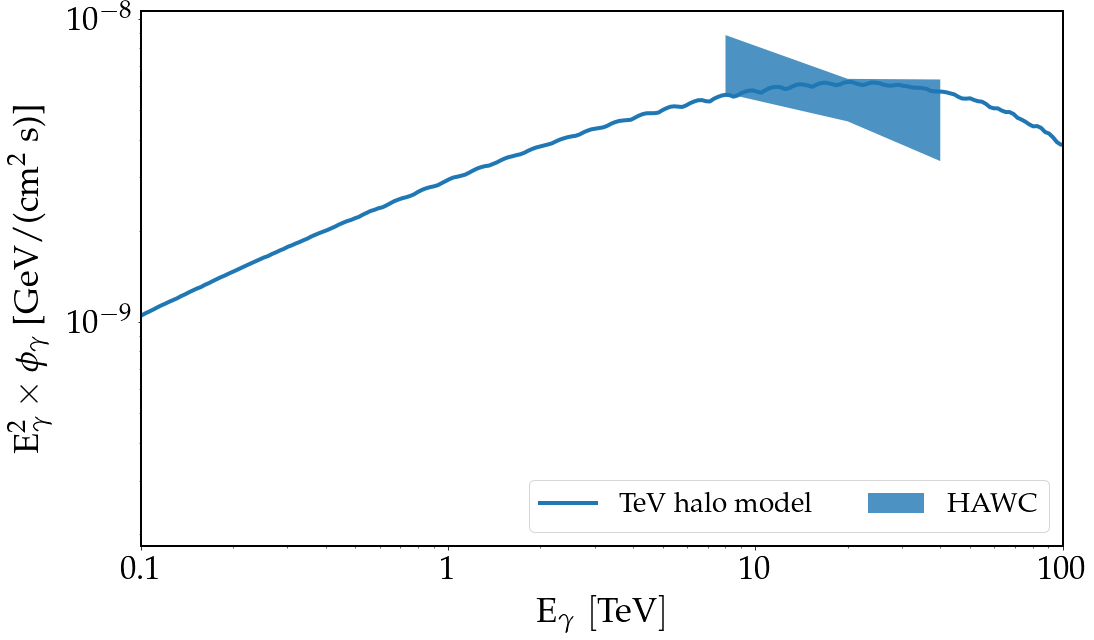

In [20]:
Geminga_distance = 250 ##pc
fig1 = plt.figure(figsize=(15.3, 9.))

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=28)
ax.tick_params(axis='both', which='minor', labelsize=28)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 7

Norm = 0.2
plt.plot(E_gamma, np.sum(epsilon, 1)*dV*(np.array(E_gamma)**(2.))/(Geminga_distance*conv_pc_cm)**2 * Norm, '-', label='TeV halo model', lw = 4)
plt.fill_between(HAWK_band_En, HAWK_band_sup, HAWK_band_low, 'r', alpha=0.8, label='HAWC') ##Be careful, this is E^2*flux

plt.xlabel(' E$_{\gamma}\,\, [\mathrm{TeV}]$',fontsize=35)
plt.ylabel(r'E$_{\gamma}^{2} \times \phi_{\gamma}$ [GeV/(cm$^2\,\, $s)]', labelpad=15, fontsize=35)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right', fontsize = 28, ncol = 3, frameon=True)
plt.yticks(fontsize=33)

plt.xlim(left=100, right = 1.e5) #, right=3.e5)
#plt.ylim(top=5e-8, bottom=2e-10)
plt.xticks([100, 1000, 10000, 100000], ['0.1', '1', '10', '100'], fontsize=33)

plt.tight_layout()

#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/TeV_gamma_CN-PR_B3_KN.png')
#plt.savefig('C:/Users/pedro/OneDrive/Escritorio/TeV_gamma_CN-PR_B3_KN.pdf')
plt.show()

In [21]:
np.sum(epsilon, 1)*dV*(np.array(E_gamma)**(2.))/(Geminga_distance*conv_pc_cm)**2 * Norm # 3D027

array([5.06962646e-10, 5.19780231e-10, 5.31119963e-10, 5.42370674e-10,
       5.54254858e-10, 5.64349485e-10, 5.71818726e-10, 5.75990143e-10,
       5.76041320e-10, 5.82062157e-10, 5.96151156e-10, 6.09100129e-10,
       6.22634348e-10, 6.35820727e-10, 6.46621965e-10, 6.54235372e-10,
       6.57830207e-10, 6.56461433e-10, 6.67415279e-10, 6.82955208e-10,
       6.98284750e-10, 7.14069159e-10, 7.28485936e-10, 7.39860742e-10,
       7.47321691e-10, 7.49873166e-10, 7.47675373e-10, 7.64182509e-10,
       7.81895745e-10, 8.00006271e-10, 8.17921523e-10, 8.33342943e-10,
       8.44964680e-10, 8.51759309e-10, 8.52520074e-10, 8.52931793e-10,
       8.73819043e-10, 8.94578388e-10, 9.15588984e-10, 9.35230700e-10,
       9.51337679e-10, 9.62770317e-10, 9.68378216e-10, 9.66754015e-10,
       9.74295946e-10, 9.98435666e-10, 1.02264329e-09, 1.04638653e-09,
       1.06741714e-09, 1.08387454e-09, 1.09453296e-09, 1.09808218e-09,
       1.09436422e-09, 1.11206670e-09, 1.14016053e-09, 1.16787320e-09,
      

### Produce 2D image 

In [21]:
def emiss(D, iE):
    return np.interp(D, r*L_ref, epsilon[iE, :])   

E = 20.01293062354086 TeV


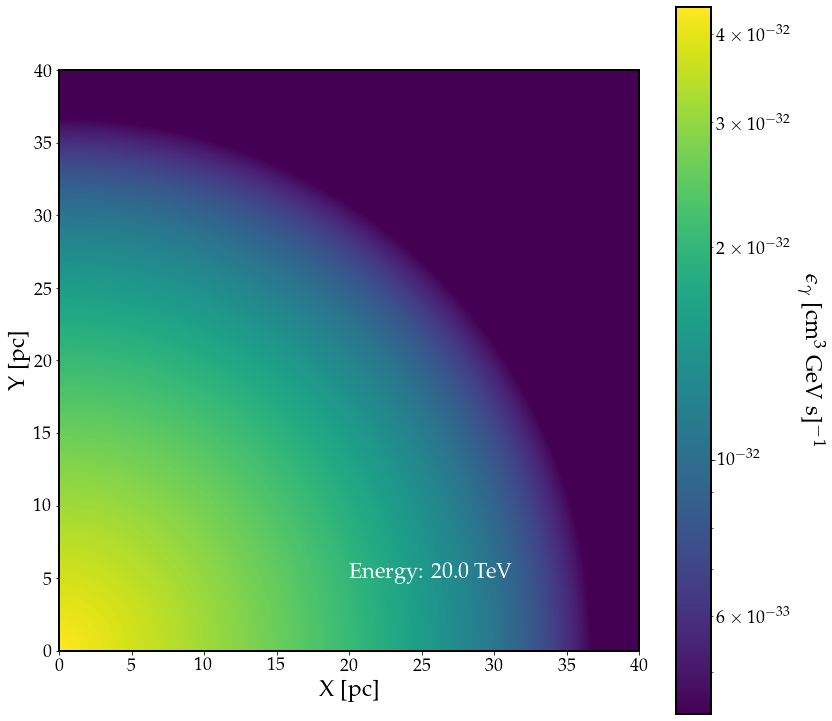

In [22]:
## Block to plot the contour plots for the same energy at different time steps and planes z, in the xy-plane ##

ien = 220             # chosen energy index
print('E =', E_gamma[ien]*1e-3, 'TeV')

x = np.linspace(0, L_ref, 50*N)
y = np.linspace(0, L_ref, 50*N)
xx, yy = np.meshgrid(x, y)
#xx, yy = np.mgrid[:N, :N]

fig = plt.figure(figsize=(13, 13))
ax = plt.gca()
       
extent = np.min(r)*L_ref, np.max(r)*L_ref, np.max(r)*L_ref, np.min(r)*L_ref
cp = plt.imshow(emiss(np.sqrt(xx**2 + yy**2), ien), animated=True, aspect='equal', cmap='viridis', extent = extent, 
                interpolation='nearest', 
                norm=matplotlib.colors.LogNorm(vmin=np.max(emiss(np.sqrt(xx**2 + yy**2), ien))/10))
                
#norm=matplotlib.colors.LogNorm(vmin=np.max(U_matrix_list[-1][:-1, 1:-1, ien+1])/1000/Renorm_list[-1], vmax=np.max(U_matrix_list[-1][:-1, 1:-1, ien+1]/Renorm_list[-1])) )
cbar = fig.colorbar(cp)
cbar.ax.get_yaxis().labelpad = 35                       
cbar.ax.set_ylabel(r'$\epsilon_{\gamma}$  [cm$^{3}$ GeV s]$^{-1}$', rotation=270, fontsize=23)
plt.text(20, 5, 'Energy: ' + str(round(E_gamma[ien]*1e-3, 1)) + ' TeV', fontsize=22, c='white')

plt.xlim(left = np.min(r), right = L_ref)
plt.ylim(bottom = np.min(r), top = L_ref)
plt.xlabel(r'X [$\mathrm{pc}$]', fontsize=23)
plt.ylabel(r'Y [$\mathrm{pc}$]', fontsize=23)#ax.xaxis.labelpad = 16
plt.savefig('C:/Users/pedro/OneDrive/Escritorio/Emissivity_map_D0{}.png'.format(round(D_ref/1.e28, 4)))
plt.show()

### Line-of-sight integration!
For the case of an isotropic distribution of gamma-rays: $$S_B = \int\epsilon dl$$, with $dl = dr/cos\alpha$, with r as the distance from the center of the object
$$S_B = 2\int_R^\infty \frac{\epsilon(r, E) rdr}{\sqrt{r^2 - D^2}}$$,
where $D$ is the angular extension that we are taking (in pc)

In [23]:
ien1 = 189
ien2 = 244
print('E from', E_gamma[ien1]*1e-3, 'to', E_gamma[ien2]*1e-3, 'TeV')

def Int_E_emiss(D):    # D is in pc!
    return np.interp(D, r*L_ref, np.sum(epsilon[ien1:ien2+1, :].T*dE_gamma[ien1:ien2+1]**2, axis=1) ) * 1e-9

E from 8.004914986416741 to 40.682167424534796 TeV


In [25]:
Sb = []
for D in (r+dr/2)*L_ref:
    dSb = lambda r_, D_: Int_E_emiss(r_) * r_ * dr/(r_**2 - D_**2)*conv_pc_cm   # D is in pc!
    Sb.append( integrate.quad( dSb, D, np.inf, args=(D), limit = 200 )[0])  
    
alpha_angle = np.arctan((r+dr/2)*L_ref/Geminga_distance)*180/np.pi #In degrees
dtheta_r = alpha_angle[1] - alpha_angle[0]

In [26]:
data_path = 'C:/Users/pedro/OneDrive/Escritorio/Projects/TeV_halos/Results-TeV_Simulations/'
data = data_path + '/HAWK-IntensityvsR.txt'  ### Units are TeV/(cm^2, s, sr)
RD, fluxD, fluxD_up, fluxD_low = np.loadtxt(data,skiprows=0,usecols=(0, 1, 2, 3), unpack=True)
errfluxD = (fluxD_low + fluxD_up)/2

ThetaD = np.array([0.43396226415094286, 1.294339622641509, 2.1698113207547167, 3.0150943396226415, 3.890566037735849, 4.735849056603774, 5.611320754716982, 6.48679245283019, 7.392452830188679, 8.207547169811322])
errorThet = (ThetaD[1:] - ThetaD[:-1])/2

Int_fact = (1/(4*np.pi)) * 1e13 * 1e3

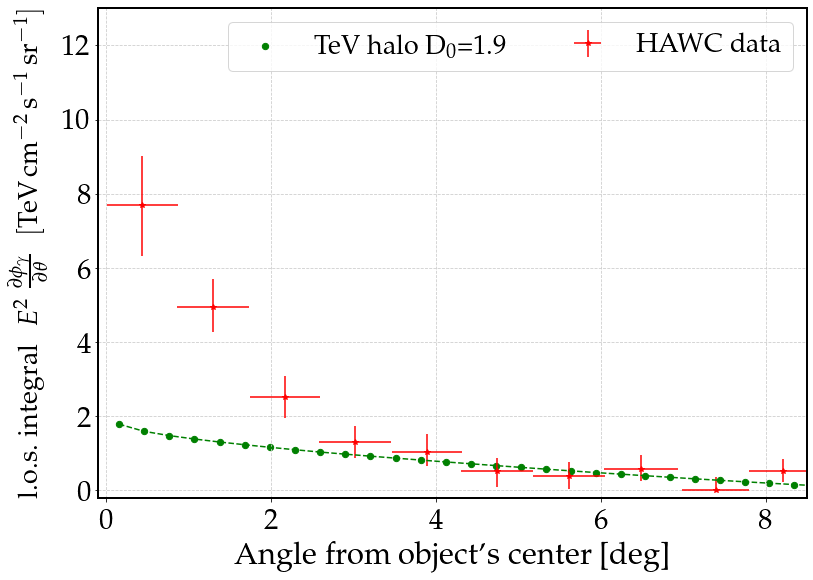

In [28]:
plt.figure(figsize=(12.7, 9.))

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=29)
ax.tick_params(axis='both', which='minor', labelsize=29)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 7

plt.errorbar(ThetaD, fluxD, yerr = [(fluxD-fluxD_low), (fluxD_up-fluxD)], xerr = np.append(errorThet, errorThet[-1]), fmt='r*', label= 'HAWC data')

Myfact = 4 #1. #0.3 #1.
plt.scatter(alpha_angle, np.array(Sb)*Myfact*Int_fact, marker='o', color='green', s=40, label=r'TeV halo D$_0$={}'.format(round(D_ref/1.e28, 2)))
plt.plot(alpha_angle, np.array(Sb)*Myfact*Int_fact , 'g--')


plt.xlabel('Angle from object\'s center [$\mathrm{deg}$]', fontsize=31)
plt.ylabel(r'l.o.s. integral \, $E^2 \,\,\frac{\partial \phi_{\gamma}}{\partial \theta}$ \, $[\mathrm{TeV \,cm^{-2} \,s^{-1} \,sr^{-1}}]$', labelpad=15, fontsize=27)

f = mticker.ScalarFormatter(useMathText=True)

plt.legend(loc='upper right', fontsize = 27, ncol = 2, frameon = True)
plt.xlim(left = -0.1, right=8.5)
plt.ylim(top=13, bottom=-0.2)
plt.grid(color='0.8', linestyle='dashed')

plt.savefig('C:/Users/pedro/OneDrive/Escritorio/Sb-D0{}.png'.format(round(D_ref/1.e28, 4)))
plt.show()